In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
np.random.seed(99)

In [3]:
N_evo_list = np.arange(20)+1
var_list = N_evo_list

In [4]:
%run ./Lorenz_data.ipynb
%run ./ESN.ipynb
%run ./Reconstruct.ipynb

N_washout = 100
N_train   = 10000
N_tstart  = 10000
N_test    = 3000

Scenario1 = [[0,1], [2,1], [3,2]] # 0←1→2→3
Scenario2 = [[0,2], [2,1], [1,0], [0,3], [4,2]]# 0←2←1←0, 3→0, 2→4
Scenarios = [Scenario1,Scenario2]

A_S = []
for s in Scenarios:
    N_x = np.max(np.array(s)) + 1
    A = np.zeros((N_x, N_x))
    for ij in s:
        i,j=ij[0],ij[1]
        A[i,j] = 1
    A_S.append(A)

sigma_dyn, sigma_obs = 1e-4, 1e-2

In [ ]:
TDI_A = []
N_data = 10

for A in A_S:
    scenario_start = time.time()
    N_x = A.shape[0]
    
    N_net = 5
    TDI_var = np.zeros((N_net, len(var_list), N_data, N_x, N_x))
    
    for data_index in range(N_data):
        X = gen_data_norm(N_x, A, N_tstart+N_test, sigma_dyn = sigma_dyn, sigma_obs = sigma_obs)
        # washout
        X_washout = X[:N_washout]
        # training
        X_t = X[N_washout:N_washout+N_train-1]
        Y_t = X[N_washout+1:N_washout+N_train]

        X_test = X[N_tstart:]

        variables = np.arange(N_x)+1

        N_dim   = 3 * N_x # dimension of inputs (and outputs)
        N_units = 100 * N_dim #units in the reservoir 

        for net in range(N_net):
            esn = ESN(N_units, N_dim, N_dim)
            esn.train(X_washout, X_t, Y_t)

            for var_index in range(len(N_evo_list)):
                n_evo = N_evo_list[var_index]
                N_rep, N_evo = 25, n_evo
                TDI_var[net, var_index, data_index, :, :] = cal_TDI(esn, X_test, N_x, 3, 0, 1, N_rep, N_washout, N_evo, j_threshold = 0.05)

    TDI = np.mean(TDI_var, axis=0)
    TDI_A.append(TDI)
    
    print(f'scenario finish, runtime={time.time() - scenario_start :.2f}')

In [13]:
%run ./Plot_TDI.ipynb

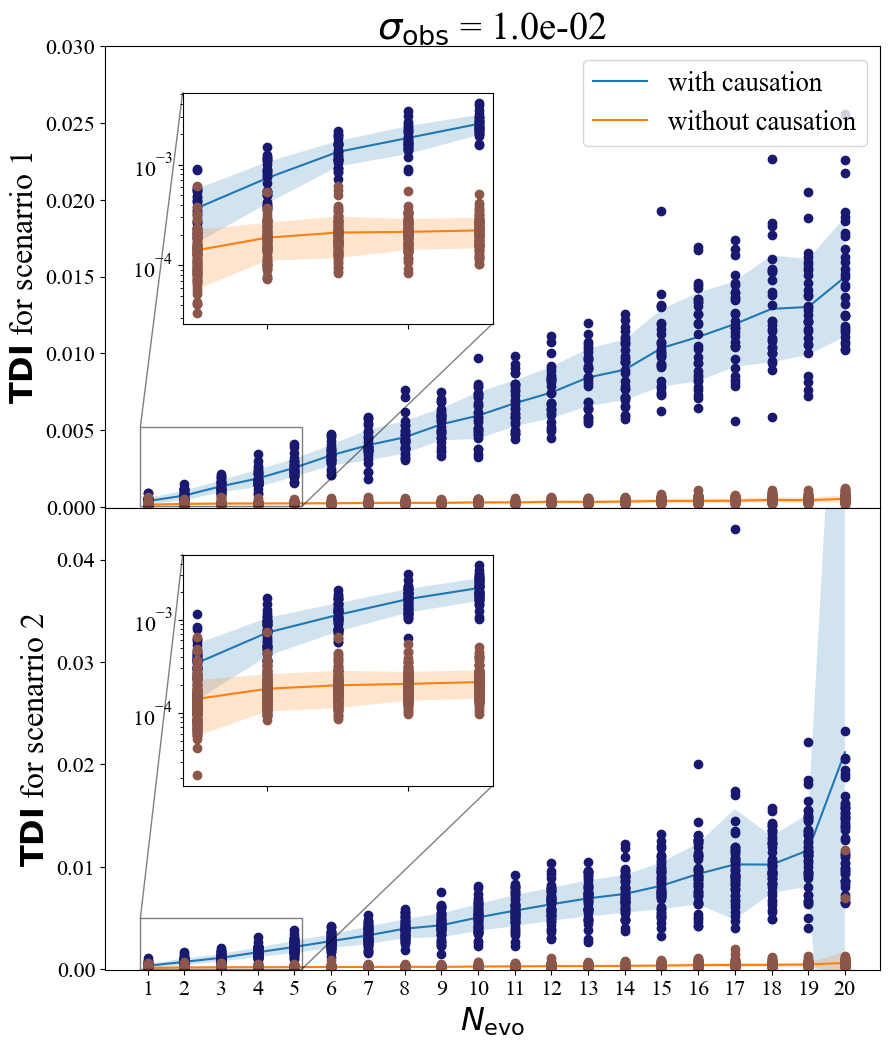

In [14]:
various_TDI_categorized = []
strength_list = [1,0]

for st_index in range(len(strength_list)):
    various_TDI_categorized.append([])
    for sc_index in range(len(A_S)):
        N_links = []
        A = A_S[sc_index]
        for s in strength_list:
            N_links.append(len(np.where(A == s)[0]))
        N_links[1] -= len(A)
        various_TDI_categorized[st_index].append(np.zeros((len(var_list), N_links[st_index] * N_data)))

for sc_index in range(len(Scenarios)):
    A = A_S[sc_index]
    for var_index in range(len(var_list)):
        TDIs = TDI_A[sc_index][var_index,:,:,:]
        TDI_cat = get_TDI_categorized(TDIs, A, strength_list)
        for st_index in range(len(strength_list)):
            various_TDI_categorized[st_index][sc_index][var_index, :] = np.array(TDI_cat[st_index])

xlabel = '$N_\mathrm{evo}$'
title = '$\sigma_\mathrm{obs}$ = '+f'{sigma_obs:.1e}'
filename = 'various_N_evo_obs1'
axins_pos = [0.10, 0.4, 0.4, 0.5]
xscale_log_inset = False
yscale_log_inset = True
inset_show_list = [0,1,2,3,4]
zoom_inset_settings = (axins_pos, xscale_log_inset, yscale_log_inset, inset_show_list) 
y_lim = [[-0.0001, 0.03], [-0.0001, 0.045]]
            
plot_various(len(Scenarios), various_list = N_evo_list, various_TDI_categorized = various_TDI_categorized, strength_list=strength_list,
             filename = filename, title = title, ylim = y_lim,
             legend_loc = 'upper right', xlabel = xlabel, x_ticks = var_list, zoom_inset_settings = zoom_inset_settings)